In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy

In [18]:
dataset = np.load('dataset_2000_epi_d_max_80.npy', allow_pickle=True)

def cal_action_reward(static_state, next_static_state, v_desired):

    if static_state[1] and not(static_state[2]):
        l1 = 0
    elif static_state[1] and static_state[2]:
        l1 = 1
    elif not(static_state[1]) and static_state[2]:
        l1 = 2

    if next_static_state[1] and not(next_static_state[2]):
        l2 = 0
    elif next_static_state[1] and next_static_state[2]:
        l2 = 1
    elif not(next_static_state[1]) and next_static_state[2]:
        l2 = 2

    action = l2-l1

    v_ego = next_static_state[0]

    if action == 0:
        Plc = 0
    else:
        Plc = 0.01

    reward = (1 - (np.abs(v_ego - v_desired)/v_desired)) - Plc

    # print(static_state[1:3], next_static_state[1:3], action, reward)

    return action, reward

def pre_processing_data(dataset):

    epi_list = []
    for episode in dataset:
        dyn_state_list = []
        static_state_list = [] 
        next_dyn_state_list = []
        next_static_state_list = []
        action_list = []
        reward_list = []

        for i, step in enumerate(episode[0:-1]):
            static_state_list.append(step[0])
            dyn_state_list.append(torch.Tensor(step[1:]))
            next_dyn_state_list.append(torch.Tensor(episode[i+1][1:]))
            next_static_state_list.append(episode[i+1][0])

            a,r = cal_action_reward(step[0], episode[i+1][0], v_desired=24)
            action_list.append(a)
            reward_list.append(r)


        epi_list.append((dyn_state_list, torch.Tensor(static_state_list), next_dyn_state_list, torch.Tensor(next_static_state_list), torch.Tensor(action_list),torch.Tensor(reward_list)))
        
    return epi_list

def transfer_weights(from_net, to_net, tau):

    from_state_dict = from_net.state_dict()
    to_state_dict = to_net.state_dict()
    
    # Scale the parameters in the state dictionary
    final_state_dict = {}
    for (k1, v1), (k2, v2) in zip(to_state_dict.items(), from_state_dict.items()):
        final_state_dict[k1] = tau* v2 + (1-tau)*v1

    
    # Load the scaled state dictionary into the destination model
    to_net.load_state_dict(final_state_dict)

    return to_net

processed_dataset = pre_processing_data(dataset)

In [19]:
class Phi(nn.Module):

    def __init__(self):
        super(Phi, self).__init__()
        self.fc1 = nn.Linear(3, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 80)
        self.relu = nn.ReLU()

    def forward(self, X_dyn):
        Phi_out = torch.zeros((len(X_dyn), self.fc3.out_features))
        for i, sample in enumerate(X_dyn):
            for x_dyn in sample:
                x = self.fc1(x_dyn)
                x = self.relu(x)
                x = self.fc2(x)
                x = self.relu(x)
                x = self.fc3(x)
                x = self.relu(x)
                Phi_out[i] = Phi_out[i]+x

        return Phi_out

class Rho(nn.Module):

    def __init__(self):
        super(Rho, self).__init__()
        self.fc1 = nn.Linear(80, 60)
        self.fc2 = nn.Linear(60, 60)
        self.fc3 = nn.Linear(60, 40)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

class Q(nn.Module):

    def __init__(self):
        super(Q, self).__init__()
        self.fc1 = nn.Linear(43, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x
    
class Agent(nn.Module):
    def __init__(self):
        super(Agent, self).__init__()
        self.phi = Phi()
        self.rho = Rho()
        self.Q = Q()

    def forward(self, dyn, static):
        static= torch.Tensor(static)
        x = self.phi(dyn)
        x = self.rho(x)
        x = torch.cat((x, static), dim=1)
        x = self.Q(x)

        return x

In [20]:
def get_balanced_dataset(processed_dataset):
    full_dataset_a0 = []
    full_dataset_lane_changed = []
    for epi in processed_dataset:
        (dyn_s1, static_s1, dyn_s2, static_s2, action_list,reward_list)=epi

        for dyn_s1s, static_s1s, dyn_s2s, static_s2s, action_s,reward_s in zip(dyn_s1, static_s1, dyn_s2, static_s2, action_list,reward_list):
            if action_s == 0:
                full_dataset_a0.append([dyn_s1s, static_s1s, dyn_s2s, static_s2s, action_s,reward_s])
            else:
                full_dataset_lane_changed.append([dyn_s1s, static_s1s, dyn_s2s, static_s2s, action_s,reward_s])

    num_samples_lane_changed = len(full_dataset_lane_changed)
    full_dataset_a0_small = full_dataset_a0[0:num_samples_lane_changed]

    new_dataset = full_dataset_a0_small + full_dataset_lane_changed

    return new_dataset


new_dataset = get_balanced_dataset(processed_dataset)

In [21]:
import random

def sample_batch(new_dataset, batch_size):
    sample_batch = random.sample(new_dataset,batch_size)
    dyn_s1, static_s1, dyn_s2, static_s2, action_list, reward_list = [],[],[],[],[],[]
    for dyn_s1s, static_s1s, dyn_s2s, static_s2s, action_lists, reward_lists in sample_batch:
        dyn_s1.append(dyn_s1s)
        static_s1.append(list(static_s1s))
        dyn_s2.append(dyn_s2s)
        static_s2.append(list(static_s2s))
        action_list.append(action_lists)
        reward_list.append(reward_lists)
    
    return dyn_s1, torch.Tensor(static_s1), dyn_s2, torch.Tensor(static_s2), torch.Tensor(action_list), torch.Tensor(reward_list)
        


In [41]:
gamma = 0.99
lr = 0.0001
tau = 0.0001
batch_size = 1000

# agent = Agent()
agent_target = deepcopy(agent)

opt = optim.Adam(agent.parameters(), lr=lr)

epochs = 1000
epoch_history = []
for epoch in range(epochs):
    epi_history = []
    batch = sample_batch(new_dataset, batch_size)
    # for epi in batch:
    (dyn_s1, static_s1, dyn_s2, static_s2, action_list,reward_list) = batch# selected an episode
    # print(action_list) # 0: keep_lane | -1: right | 1:left
    action_list = action_list.numpy().astype(int)+1
    # print(action_list) # 1: keep_lane | 0: right | 2:left
    

    q_from_target_net = agent_target.forward(dyn_s2, static_s2)
    
    y = reward_list + gamma*torch.max(q_from_target_net, dim=1)[0]

    q_out = agent.forward(dyn_s1, static_s1)
    print(np.argmax(q_from_target_net.detach().cpu().numpy(),axis=1), q_out[10].detach().cpu().numpy())
    q_out = q_out[torch.arange(len(action_list)), action_list]

    mse = torch.nn.functional.mse_loss(q_out, y)
    epi_history.append(float(mse.detach()))

    mse.backward()

    opt.step()

    agent_target.zero_grad()
    agent.zero_grad()

    agent_target = transfer_weights(from_net = agent, to_net=agent_target, tau = tau)
        
    print(f"loss for epoch {epoch}: ",sum(epi_history)/len(epi_history))
    epoch_history.append(sum(epi_history)/len(epi_history))

torch.save(agent, "agent.pt")
torch.save(agent_target, "agent_target.pt")

[2 2 0 1 1 1 1 1 1 1 1 0 1 1 1 1 2 1 1 0 1 0 1 0 1 0 1 2 0 2 1 1 1 1 0 2 0
 2 1 1 2 0 0 1 1 0 1 2 1 1 1 1 1 0 2 1 0 1 2 1 1 1 1 0 2 1 1 1 1 1 0 0 0 0
 0 1 1 1 1 1 2 0 1 1 1 1 0 0 1 0 2 0 1 1 1 0 1 0 1 1 1 2 1 1 1 2 1 2 0 1 1
 1 1 0 2 0 1 2 0 1 2 1 1 1 1 1 0 0 1 1 0 2 1 0 1 0 2 0 1 1 1 0 0 0 1 2 1 1
 0 0 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 2 1 2 1 2 1 1 1 0 1 1
 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 2 1 2 2 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1
 1 0 1 1 1 0 1 0 1 1 2 1 1 2 0 2 1 1 0 2 1 1 1 1 0 2 2 1 1 1 0 1 0 1 0 1 1
 1 1 1 2 1 1 0 1 2 1 0 1 1 0 1 0 1 1 2 1 0 1 1 1 1 1 2 1 1 2 1 2 1 0 1 1 1
 1 1 1 1 0 1 2 1 1 1 1 2 0 2 1 1 1 1 1 2 2 1 2 1 2 1 2 1 1 1 1 2 1 1 1 1 1
 1 1 0 1 1 2 1 0 0 1 1 1 0 1 0 2 1 2 1 1 1 1 1 2 1 0 0 1 1 2 1 1 0 1 1 2 2
 2 1 1 1 1 1 0 1 1 1 1 1 1 1 1 2 1 1 1 1 0 0 1 1 1 1 0 0 1 1 2 1 0 1 0 1 1
 1 1 1 0 2 0 1 1 2 0 2 1 1 1 1 1 1 1 1 1 2 1 1 1 0 2 1 1 1 1 1 0 2 1 1 0 1
 2 0 2 1 0 1 1 1 2 0 1 1 1 0 1 2 2 1 2 0 1 1 1 1 1 0 2 2 2 1 1 0 1 1 0 1 1
 1 1 1 0 1 1 1 1 1 1 1 2 

In [42]:
torch.save(agent, "agent_loss_0.17_epoch_999.pt")
torch.save(agent_target, "agent_target_loss_0.17_epoch_999.pt")

In [50]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy
import traci.constants as tc
import traci

def get_vehicle_attr_dict_list(vehicle_types, num_vehicles=50, num_lanes = 3):
    vehicle_types = list(vehicle_types)
    vehicle_types.remove('ego')
    vehicle_types = [word for word in vehicle_types if not word.isupper()]

    vehicle_attr_list = []
    v_num_ego = np.clip(int(np.random.normal(num_vehicles//2, num_vehicles//2)), 1, num_vehicles-1)

    for v_id in range(num_vehicles):
        u = np.random.randint(-5,6)
        # v_id, typeID, max_speed, ic_speed_gain, pos, lane
        typeID = np.random.choice(vehicle_types)
        max_speed = traci.vehicletype.getMaxSpeed(typeID) + u
        ic_speed_gain = np.random.randint(10,21)
        pos = 0
        lane = np.random.randint(0,num_lanes)
        vehicle = {'id':str(v_id), 'typeID':typeID, 'max_speed':str(max_speed), 'ic_speed_gain':str(ic_speed_gain), 'pos':pos, 'lane':str(lane)}
        vehicle_attr_list.append(vehicle)


        if v_id == v_num_ego:
            ego_vehicle = {'id':'ego', 'typeID':'ego', 'max_speed':"", 'ic_speed_gain':"", 'pos':pos, 'lane':str(np.random.randint(0,num_lanes))}
            vehicle_attr_list.append(ego_vehicle)

        # print(vehicle_attr_list[-1])

    return vehicle_attr_list


def collect_step_data(d_max):

    vehicle_list = []
    if 'ego' in traci.vehicle.getIDList():
        ego_pos = np.array(traci.vehicle.getPosition('ego'))
        v_ego = traci.vehicle.getSpeed('ego')
        ego_lane = int(traci.vehicle.getLaneID('ego')[-1])
        if ego_lane == 0:
            left_lane_av = 1
            right_lane_av = 0
        elif ego_lane == 1:
            left_lane_av = 1
            right_lane_av = 1
        elif ego_lane == 2:
            left_lane_av = 0
            right_lane_av = 1

        vehicle_list.append([v_ego, left_lane_av, right_lane_av])

        for vehicle_id in traci.vehicle.getIDList():
            vehicle_pos = np.array(traci.vehicle.getPosition(vehicle_id))
            vehicle_speed = traci.vehicle.getSpeed(vehicle_id)
            vehicle_lane = int(traci.vehicle.getLaneID(vehicle_id)[-1])

            # dr = (vehicle_pos-ego_pos)/d_max
            dr = (traci.vehicle.getDistance(vehicle_id)-traci.vehicle.getDistance('ego'))/d_max
            dv = (vehicle_speed-v_ego)/(v_ego+0.001)
            dl = vehicle_lane - ego_lane

            if np.abs(dr)<1 and not(vehicle_id=="ego"):
                
                vehicle_list.append([dv, dr, dl])

    return np.array(vehicle_list)


def run_episode(agent, vehicle_attr_list, d_max):
    episode_data = []
    i = 0
    while traci.simulation.getMinExpectedNumber() > 0:
        
        traci.simulationStep()
        # time.sleep(0.00000001)
        
        
        if i<len(vehicle_attr_list):
            v_param = vehicle_attr_list[i]

            if v_param['id']=='ego':
                traci.vehicle.addLegacy(v_param['id'], "route_0",pos=v_param['pos'], lane=v_param['lane'], speed=0, typeID=v_param['typeID'])
                traci.vehicle.setLaneChangeMode('ego', 512)
            else:
                traci.vehicle.addLegacy(v_param['id'], "route_0",pos=v_param['pos'], lane=v_param['lane'], speed=0, typeID=v_param['typeID'])
                traci.vehicle.setMaxSpeed(v_param['id'], v_param['max_speed'])
                traci.vehicle.setParameter(v_param['id'], tc.LCA_SPEEDGAIN, v_param['ic_speed_gain']) # set the icSpeedGain of the new vehicle
        i = i+1

    
        vehicle_list = collect_step_data(d_max = d_max)
        if len(vehicle_list)>0:
            episode_data.append(vehicle_list)
        
        if len(episode_data)>1 and len(vehicle_list)==0:
            break

        if 'ego' in traci.vehicle.getIDList():
            static_state = torch.Tensor([vehicle_list[0]])
            dyn_state = torch.Tensor([vehicle_list[1:]])

            
            prediction = agent.forward(dyn_state, static_state).detach().cpu().numpy()[0]
            
            a = np.argmax(prediction)
            lane_idx = traci.vehicle.getLaneIndex('ego')
            
            target_lane_idx = lane_idx + (a-1) 

            print("action: ", a)
            
            if target_lane_idx<3 and target_lane_idx>=0:
                traci.vehicle.changeLane('ego', target_lane_idx, 0)
        

    return np.array(episode_data, dtype=object)

# agent = torch.load('agent_target.pt')

traci.start(["sumo-gui", "-c", "data_collection/sumo_circuler_net/circle_env.sumocfg"])

vehicle_types = traci.vehicletype.getIDList()
vehicle_attr_list = get_vehicle_attr_dict_list(vehicle_types, num_vehicles=40)

episode_data = run_episode(agent, vehicle_attr_list, d_max=80)

traci.close()

 Retrying in 1 seconds
Could not connect to TraCI server at localhost:59695 [Errno 61] Connection refused
 Retrying in 1 seconds
Could not connect to TraCI server at localhost:59695 [Errno 61] Connection refused
 Retrying in 1 seconds
Could not connect to TraCI server at localhost:59695 [Errno 61] Connection refused
 Retrying in 1 seconds
Could not connect to TraCI server at localhost:59695 [Errno 61] Connection refused
 Retrying in 1 seconds
Could not connect to TraCI server at localhost:59695 [Errno 61] Connection refused
 Retrying in 1 seconds
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:  1
action:

error: xp_attach_gl_context returned: 2
X Error: code 161 major 149 minor 5: GLXBadContext.
X Fatal error.


In [49]:
traci.close()

FatalTraCIError: Not connected.

In [47]:
traci.close()

FatalTraCIError: Not connected.

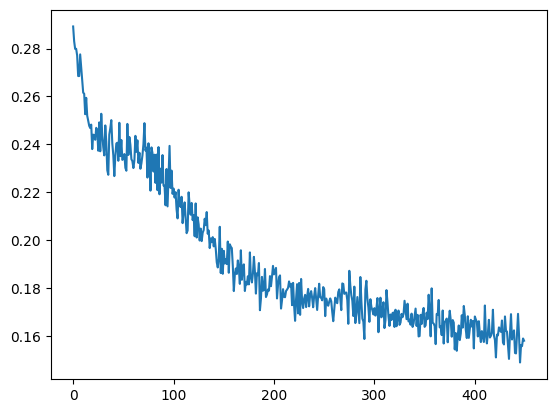

In [25]:
import matplotlib.pyplot as plt

plt.plot(epoch_history)